In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

import tfz
from utils import plot_mfs

%matplotlib inline
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (15, 8)

In [10]:
SUBJECT = 'all'
ARCHITECTURE = 3, 3, 2, 2, 2, 3, 3

arch_file = 'fcs-description-{}-{}.csv'.format(SUBJECT, '-'.join(str(x) for x in ARCHITECTURE))
outp_file = 'fcs-outputs-{}-{}.csv'.format(SUBJECT, '-'.join(str(x) for x in ARCHITECTURE))

In [11]:
VARIABLES = (
    'Leader distance', 'Next TLS distance', 'Next TLS green',
    'Next TLS yellow', 'Next TLS red', 'Speed', 'Speed to leader',
)
DOMAINS = (
    (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 20), (-20, 20)
)
VARS = [''.join(s[:1].upper() + s[1:] for s in i.split(' ')) for i in VARIABLES]
NUM_FUZZY_OUTPUTS = 2

## Mejor arquitectura

In [12]:
row_ini = pd.read_csv(arch_file).iloc[0]
row_end = pd.read_csv(arch_file).iloc[-1]
row_end

LeaderDistance/b                                                        0
LeaderDistance/s0                                                0.102786
LeaderDistance/s1                                                0.306962
LeaderDistance/s2                                                0.361548
LeaderDistance/s3                                                0.341286
NextTLSDistance/b                                                       0
NextTLSDistance/s0                                            -0.00642111
NextTLSDistance/s1                                               0.497861
NextTLSDistance/s2                                             0.00788608
NextTLSDistance/s3                                               0.179748
NextTLSGreen/b                                                          0
NextTLSGreen/s0                                                  0.333333
NextTLSGreen/s1                                                  0.333333
NextTLSRed/b                          

### Particiones

In [13]:
variables_values_ini = []
variables_values_end = []
for variable in VARS:
    keys_ini = [c for c in row_ini.keys() if c.startswith(variable + '/')]
    keys_end = [c for c in row_end.keys() if c.startswith(variable + '/')]
    variables_values_ini.append({k.split('/')[-1]: row_ini[k] for k in keys_ini})
    variables_values_end.append({k.split('/')[-1]: row_end[k] for k in keys_end})

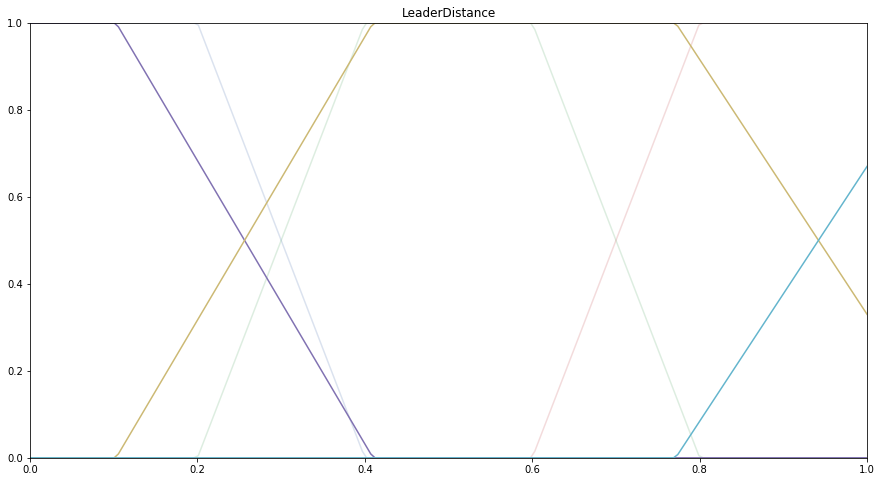

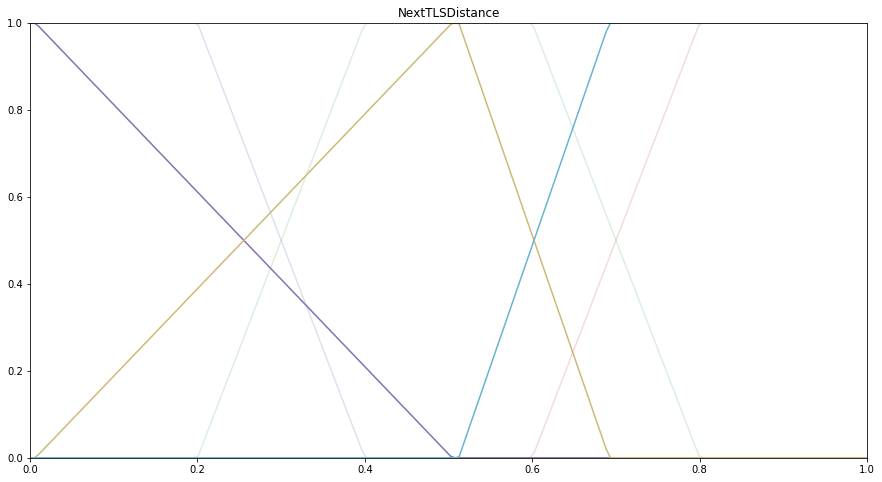

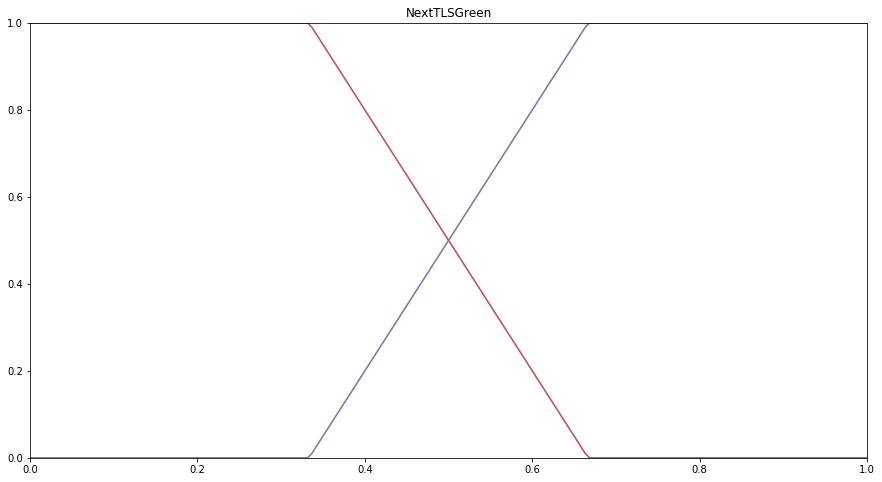

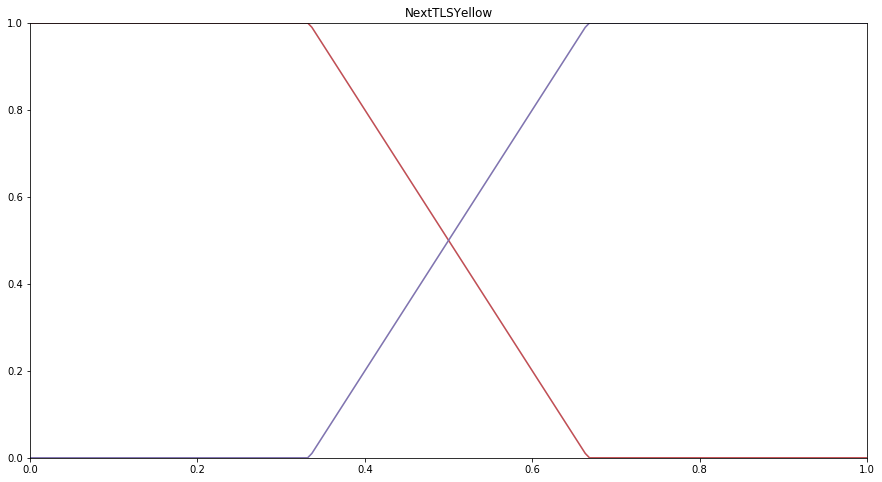

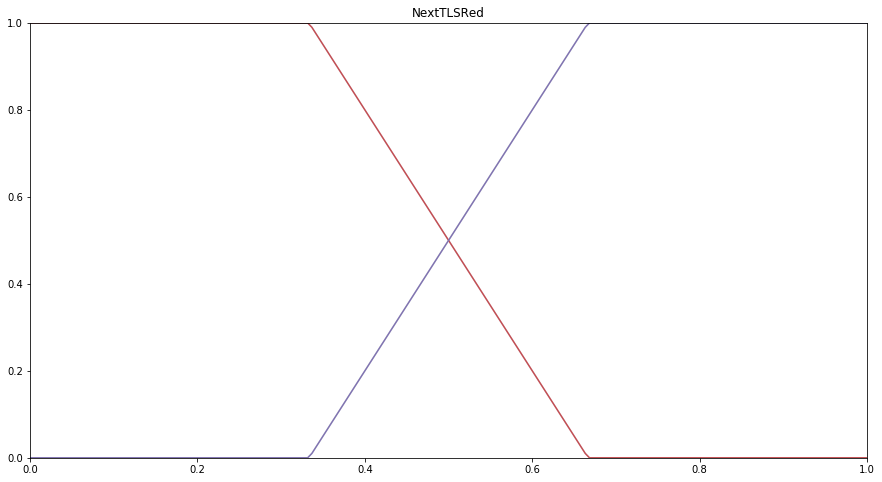

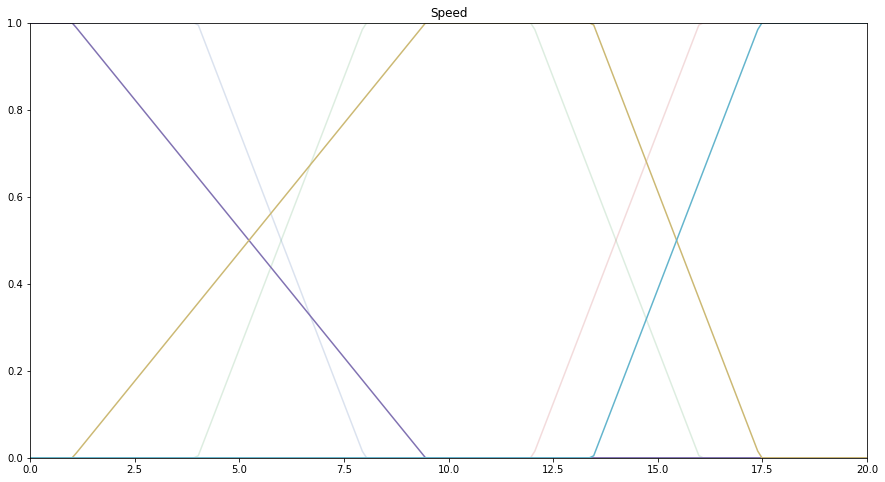

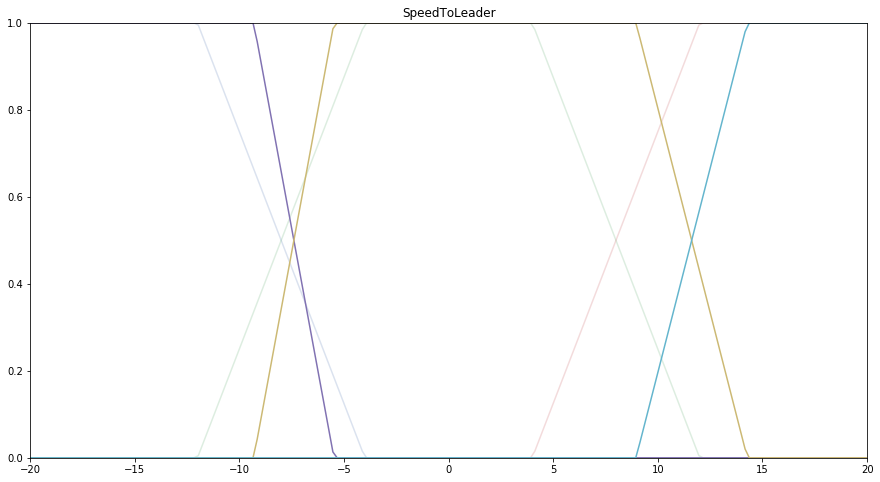

In [14]:
for i, (name, desc_ini, desc_end, (min_x, max_x)) in enumerate(zip(VARS, variables_values_ini, variables_values_end, DOMAINS)):
    tf.reset_default_graph()
    
    
    for k, v in desc_ini.items():
        if k != 'b':
            desc_ini[k] = np.abs(v)
            desc_end[k] = np.abs(desc_end[k])

    # Input data
    x = tf.placeholder(dtype=tf.float32)
    
    # Variables
    
    num_fs = ((len(desc_ini) - 1) // 2) + 1
    base = tf.constant(desc_ini['b'], dtype=tf.float32)
    next_fs_starting_point = base + desc_ini['s0']
    mfs_ini = []
    for i in range(num_fs):
        if i == 0:
            mf = tfz.slope_desc(x, next_fs_starting_point, desc_ini['s1'])
        elif i == num_fs - 1:
            mf = tfz.slope_asc(x, next_fs_starting_point, desc_ini['s' + str(len(desc_ini) - 2)])
        else:
            sta = ['s' + str(i) for i in range(i * 2 - 1, i * 2 + 2)]
            mf = tfz.trapezoid(x, next_fs_starting_point, desc_ini[sta[0]], desc_ini[sta[1]], desc_ini[sta[2]])
            next_fs_starting_point += desc_ini[sta[0]] + desc_ini[sta[1]]
        mfs_ini.append(mf)
    base = tf.constant(desc_end['b'], dtype=tf.float32)
    next_fs_starting_point = base + desc_end['s0']
    mfs_end = []
    for i in range(num_fs):
        if i == 0:
            mf = tfz.slope_desc(x, next_fs_starting_point, desc_end['s1'])
        elif i == num_fs - 1:
            mf = tfz.slope_asc(x, next_fs_starting_point, desc_end['s' + str(len(desc_end) - 2)])
        else:
            sta = ['s' + str(i) for i in range(i * 2 - 1, i * 2 + 2)]
            mf = tfz.trapezoid(x, next_fs_starting_point, desc_end[sta[0]], desc_end[sta[1]], desc_end[sta[2]])
            next_fs_starting_point += desc_end[sta[0]] + desc_end[sta[1]]
        mfs_end.append(mf)

    X = np.reshape(np.linspace(min_x, max_x, 200), (-1, 1))

    with tf.Session() as session:
        fig, ax = plt.subplots(1, 1)
        ax.set_title(name)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(0, 1)

        for Y in session.run(mfs_ini, feed_dict={x: X}):
            ax.plot(X, Y, alpha=0.2)
        for Y in session.run(mfs_end, feed_dict={x: X}):
            ax.plot(X, Y)

## Reglas

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

weights = row_end['fuzzy_output_weights']
weights = np.float32(weights.split(';'))
weights = np.reshape(weights, [NUM_FUZZY_OUTPUTS, np.prod(ARCHITECTURE)])
weights = np.round(sigmoid(weights))

In [16]:
fuzzy_sets = []
for var, num_fs in zip(VARS, ARCHITECTURE):
    fuzzy_sets.append(['{} IS f{}'.format(var, i) for i in range(1, num_fs + 1)])

antecedents = (
    'IF ' + ' AND '.join(ants) + ' THEN '
    for ants in itertools.product(*fuzzy_sets)
)

for antecedent, (ws) in zip(antecedents, weights):
        if ws[0]:
            print(antecedent + 'Acceleration IS Decel')
        if ws[1]:
            print(antecedent + 'Acceleration IS Accel')

IF LeaderDistance IS f1 AND NextTLSDistance IS f1 AND NextTLSGreen IS f1 AND NextTLSYellow IS f1 AND NextTLSRed IS f1 AND Speed IS f1 AND SpeedToLeader IS f1 THEN Acceleration IS Decel
IF LeaderDistance IS f1 AND NextTLSDistance IS f1 AND NextTLSGreen IS f1 AND NextTLSYellow IS f1 AND NextTLSRed IS f1 AND Speed IS f1 AND SpeedToLeader IS f1 THEN Acceleration IS Accel
IF LeaderDistance IS f1 AND NextTLSDistance IS f1 AND NextTLSGreen IS f1 AND NextTLSYellow IS f1 AND NextTLSRed IS f1 AND Speed IS f1 AND SpeedToLeader IS f2 THEN Acceleration IS Decel
IF LeaderDistance IS f1 AND NextTLSDistance IS f1 AND NextTLSGreen IS f1 AND NextTLSYellow IS f1 AND NextTLSRed IS f1 AND Speed IS f1 AND SpeedToLeader IS f2 THEN Acceleration IS Accel
